# Time Series Style Transfer

In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from configs.SimulatedData import Proposed
from dataset.tf_pipeline import make_train_valid_dset
from datetime import datetime
import io
import json
import os
from utils.metric import signature_on_batch, signature_metric

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized.
    print(e)

1 Physical GPUs, 1 Logical GPUs


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [64]:
config = Proposed()
date_str = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

D1_PATH = "data/simulated_dataset/01 - Source Domain.h5"
D2_PATH = "data/simulated_dataset/time_shift/14.h5"
EXPERIMENT_NAME = f"{date_str} - Style Transfer Algorithm"
SAVE_FOLDER = f"experiments_logs/{EXPERIMENT_NAME}"

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS =  config.batch_size
EPOCHS = 2 # config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate

STYLE_VECTOR_SIZE = 16
FEAT_WIENER = 2
N_SAMPLE_WIENER = SEQUENCE_LENGTH//4
NOISE_DIM= (N_SAMPLE_WIENER, FEAT_WIENER)
N_VALIDATION_SEQUENCE = 500
TRIPLET_R = 1

BASE_DIR = f"logs/{EXPERIMENT_NAME}"
TRAIN_LOGS_DIR_PATH = f"{BASE_DIR}/train"
VALID_LOGS_DIR_PATH = f"{BASE_DIR}/valid"
GENERATION_LOG = f"{BASE_DIR}/Generations"
os.makedirs(GENERATION_LOG)
os.makedirs(SAVE_FOLDER)

In [92]:
def save_configuration():
    d = {
        "d1_path":D1_PATH,
        "d2_path":D2_PATH,
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "n_validation_sequence":N_VALIDATION_SEQUENCE,
        "log_dir":BASE_DIR
    }

    json_object = json.dumps(d)
    with open(f"{SAVE_FOLDER}/parameters.json", "w") as outfile:
        outfile.write(json_object)

# Load the Datasets

In [66]:
def train_valid_split(df, train_size:float=.7):
    dset_size = df.shape[0]
    train_index = int(dset_size* train_size)

    train_split = df.loc[:train_index]
    valid_split = df.loc[train_index:]

    return train_split, valid_split

In [67]:
df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
df_d2= pd.read_hdf(D2_PATH).astype(np.float32)

df_d1 = df_d1.drop(columns=['labels'])
df_d2 = df_d2.drop(columns=['labels'])

N_FEAT = df_d1.shape[1]

dset_d1_train, dset_d1_valid = make_train_valid_dset(
    df_d1, 
    SEQUENCE_LENGTH, 
    GRANUARITY, 
    int(OVERLAP* SEQUENCE_LENGTH),
    BS
)

dset_d2_train, dset_d2_valid = make_train_valid_dset(
    df_d2, 
    SEQUENCE_LENGTH, 
    GRANUARITY, 
    int(OVERLAP* SEQUENCE_LENGTH),
    BS,
)

## Make Content Encoder

In [68]:
# Define AdaIN Layers for Time Series
class AdaIN(tf.keras.layers.Layer):
    def __init__(self):
        super(AdaIN, self).__init__()

    def get_mean_std(self, x, eps=1e-5):
        _mean, _variance = tf.nn.moments(x, axes=[1], keepdims=True)
        standard_dev = tf.sqrt(_variance+ eps)
        return _mean, standard_dev

    def call(self, content_input, style_input):
        # print(content_input.shape, style_input.shape)
        content_mean, content_std = self.get_mean_std(content_input)
        style_mean, style_std = self.get_mean_std(style_input)
        adain_res =style_std* (content_input - content_mean) / content_std+ style_mean
        return adain_res

In [69]:
def make_content_encoder(seq_length:int, n_feat:int, feat_wiener:int):
    _input = tf.keras.Input((seq_length, n_feat,))

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(_input)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(feat_wiener, 5, 1, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model(_input, x)

    return model

def make_style_encoder(seq_length:int, n_feat:int, vector_output_shape:int):
    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(_input)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(vector_output_shape)(x)

    model = tf.keras.Model(_input, x)

    return model


def make_decoder(n_sample_wiener:int, feat_wiener:int, style_vector_size:int, out_feat:int):
    _content_input = tf.keras.Input((n_sample_wiener, feat_wiener))
    _style_input = tf.keras.Input((style_vector_size, 1))


    _style_embedding_hidden = tf.keras.layers.Conv1DTranspose(32, 5, 1, padding='same')(_style_input)
    _style_embedding = tf.keras.layers.Conv1DTranspose(1, 5, 1, padding='same')(_style_embedding_hidden)

    _upsampled_style= tf.keras.layers.Conv1DTranspose(32, 5, 2, padding='same')(_style_embedding)
    _upsampled_style= tf.keras.layers.Conv1DTranspose(1, 5, 1, padding='same')(_upsampled_style)

    x = AdaIN()(_content_input, _style_embedding)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = AdaIN()(x, _upsampled_style)
    x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1DTranspose(out_feat, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model([_content_input, _style_input], x)
    return model


def make_discriminator(seq_length:int, n_feat:int):
    _input = tf.keras.Input((seq_length, n_feat))
    x = tf.keras.layers.Conv1D(16, 5, 2, padding='same')(_input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv1D(16, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    _output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(_input, _output)

    return model

In [70]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, df_d1.shape[1], FEAT_WIENER)
# content_encoder.summary()

In [71]:
style_encoder = make_style_encoder(SEQUENCE_LENGTH, df_d1.shape[1], STYLE_VECTOR_SIZE)
# style_encoder.summary()

In [72]:
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE ,df_d1.shape[1])
# decoder.summary()

In [73]:
global_discriminator = make_discriminator(SEQUENCE_LENGTH, df_d1.shape[1])

In [74]:
class StyleTransferModel(tf.keras.Model):
    def __init__(self, seq_length:int, n_feat:int, style_vector_shape:int, n_sample_wiener:int, feat_wiener:int, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.content_encoder= make_content_encoder(seq_length, n_feat, feat_wiener)
        self.style_encoder = make_style_encoder(seq_length, n_feat, style_vector_shape)
        self.decoder = make_decoder(n_sample_wiener, feat_wiener, style_vector_shape, n_feat)

    def __call__(self, content_sequence, style_sequence):
        encoded_content = self.content_encoder(content_sequence)
        encoded_style = self.style_encoder(style_sequence)

        print(encoded_content.shape, encoded_style.shape)

        generated_sequence = self.decoder([encoded_content, encoded_style])

        return generated_sequence

In [75]:
def generate(content_batch, style_batch):
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    return generated

In [76]:
seed_content_batch = next(iter(dset_d1_valid))
seed_style_batch = next(iter(dset_d2_valid))

generated_sequence = generate(seed_content_batch, seed_style_batch)

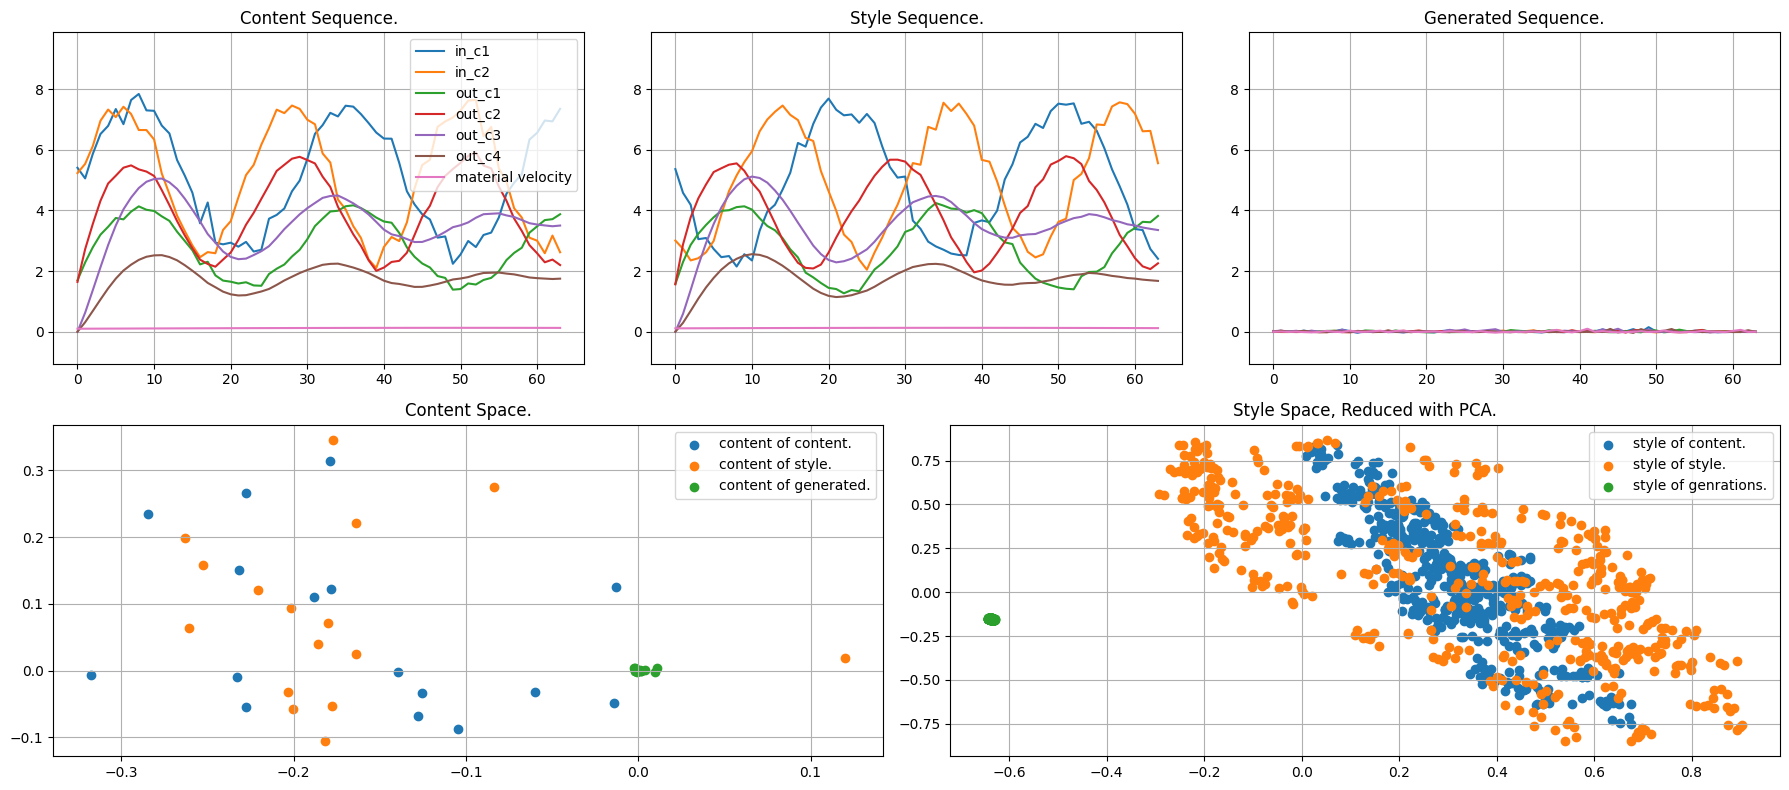

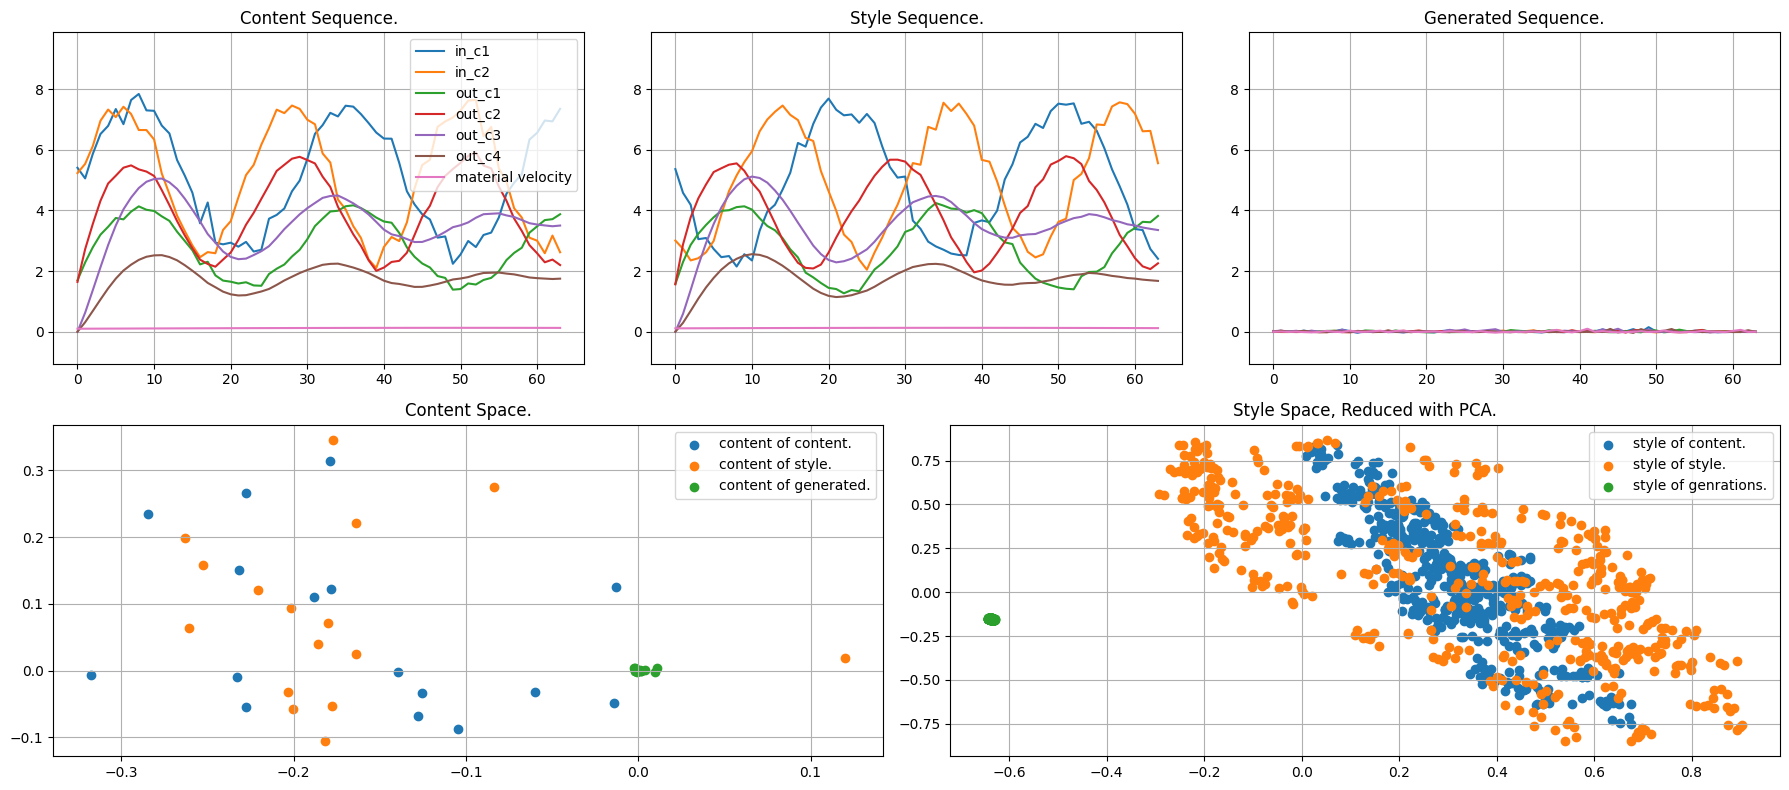

In [77]:
from sklearn.decomposition import PCA

def plot_generated_sequence2(content_sequences, style_sequences, show=False):

    # Compute what we need
    content_of_content = content_encoder(content_sequences, training=False)
    style_of_content = style_encoder(content_sequences, training=False)

    content_of_style= content_encoder(style_sequences, training=False)
    style_of_style= style_encoder(style_sequences, training=False)

    generated_sequences = decoder([content_of_content, style_of_style], training=False)

    content_of_generated = content_encoder(generated_sequences, training=False)
    style_of_generated = style_encoder(generated_sequences, training=False)

    # Reduce the Style Vector for visualization purposes.
    pca = PCA(2)
    all_together = np.vstack([style_of_content, style_of_style, style_of_generated])

    pca.fit(all_together)

    reduced_style_style = pca.transform(style_of_style)
    reduced_style_content=pca.transform(style_of_content)
    reduced_style_generations=pca.transform(style_of_generated)

    all_values = np.array([content_sequences, style_sequences, generated_sequences])
    _min, _max = np.min(all_values)-1, np.max(all_values)+ 1


    fig= plt.figure(figsize=(18, 8))
    spec= fig.add_gridspec(2, 6)

    ax00 = fig.add_subplot(spec[0, :2])
    ax00.set_title('Content Sequence.')
    ax00.plot(content_sequences[0], label=df_d1.columns)
    ax00.set_ylim(_min, _max)
    ax00.grid(True)
    ax00.legend()

    ax01 = fig.add_subplot(spec[0, 2:4])
    ax01.set_title('Style Sequence.')
    ax01.plot(style_sequences[0])
    ax01.set_ylim(_min, _max)
    ax01.grid(True)

    ax02 = fig.add_subplot(spec[0, 4:])
    ax02.set_title('Generated Sequence.')
    ax02.plot(generated_sequences[0])
    ax02.set_ylim(_min, _max)
    ax02.grid(True) 

    ax10 = fig.add_subplot(spec[1, :3])
    ax10.set_title('Content Space.')
    ax10.scatter(content_of_content[0, :, 0], content_of_content[0, :, 1],  label='content of content.')
    ax10.scatter(content_of_style[0, :, 0], content_of_style[0, :, 1], label='content of style.')
    ax10.scatter(content_of_generated[0, :, 0], content_of_generated[0, :, 1],  label='content of generated.')
    ax10.grid(True)
    ax10.legend()

    ax11 = fig.add_subplot(spec[1, 3:])
    ax11.set_title('Style Space, Reduced with PCA.')
    ax11.scatter(reduced_style_content[:, 0], reduced_style_content[:, 1], label='style of content.')
    ax11.scatter(reduced_style_style[:, 0], reduced_style_style[:, 1], label='style of style.')
    ax11.scatter(reduced_style_generations[:, 0], reduced_style_generations[:, 1], label='style of genrations.')

    ax11.grid(True)
    ax11.legend()

    plt.tight_layout()

    return fig

plot_generated_sequence2(seed_content_batch, seed_style_batch)

In [78]:
# def plot_style_transfered_time_series(content_ts, style_ts, generated_ts, show=True, save_to:str=None):
#     all_values = np.array([content_ts, style_ts, generated_ts])
#     _min, _max = np.min(all_values)-1, np.max(all_values)+ 1
#     n_series = 3

#     fig = plt.figure(figsize=(18, 10))
#     plt.suptitle("Visualization of the generations", fontsize=18)
#     for i in range(n_series):
#         ax = plt.subplot(3, n_series, n_series* i+ 1)
#         ax.set_title(f"*[{i}]* Content Time Series >")
#         ax.plot(content_ts[i])
#         ax.set_ylim(_min, _max)
#         ax.grid(True)

#         ax = plt.subplot(3, n_series, n_series* i+ 2)
#         ax.set_title(f"*[{i}]* Style Time Series. >")
#         ax.plot(style_ts[i])
#         ax.set_ylim(_min, _max)
#         ax.grid(True)

#         ax = plt.subplot(3, n_series, n_series* i+ 3)
#         ax.set_title(f"*[{i}]* Generated Time Series.")
#         ax.plot(generated_ts[i])
#         ax.set_ylim(_min, _max)
#         ax.grid(True)

#     plt.tight_layout()

#     if not save_to is None:
#         fig.savefig(save_to)
    
#     if show:
#         plt.show()

#     return fig

# generation_figure = plot_style_transfered_time_series(seed_content_batch, seed_style_batch, generated_sequence)

In [79]:
def fig_to_buff(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf

## Define losses.

In [80]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def recontruction_loss(true:tf.Tensor, generated:tf.Tensor):
    diff = generated- true
    result = tf.math.reduce_mean(tf.square(diff))
    return result

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = encoded_content_fake- encoded_content_real
    return tf.reduce_mean(tf.square(diff))



## Tensorboard Logs.

In [81]:
# Train Metrics
met_generator_train = tf.keras.metrics.Mean(name="Train generator Loss")
met_style_encoder_train = tf.keras.metrics.Mean(name="Train Style Encoder Loss")
met_content_encoder_train= tf.keras.metrics.Mean(name="Train Content Encoder Loss")
met_disc_loss_train= tf.keras.metrics.Mean(name="Train Discriminatir Loss")

# Valid Metrics
met_generator_valid = tf.keras.metrics.Mean(name="valid generator Loss")
met_style_encoder_valid = tf.keras.metrics.Mean(name="valid Style Encoder Loss")
met_content_encoder_valid= tf.keras.metrics.Mean(name="valid Content Encoder Loss")
met_disc_loss_valid= tf.keras.metrics.Mean(name="valid Discriminatir Loss")
met_correlation_metric_valid = tf.keras.metrics.Mean(name="Correlation Metric")

In [82]:


TRAIN_SUMMARY_WRITER = tf.summary.create_file_writer(TRAIN_LOGS_DIR_PATH)
VALID_SUMMARY_WRITER = tf.summary.create_file_writer(VALID_LOGS_DIR_PATH)

def log_train_losses(epoch, plot_buf):
    image = tf.image.decode_png(plot_buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    with TRAIN_SUMMARY_WRITER.as_default():
        tf.summary.scalar("Generator Loss", met_generator_train.result(), step=epoch)
        tf.summary.scalar("Style Loss", met_style_encoder_train.result(), step=epoch)
        tf.summary.scalar("Content Loss", met_content_encoder_train.result(), step=epoch)
        tf.summary.scalar("Discriminator Loss", met_disc_loss_train.result(), step=epoch)
        
        tf.summary.image("Training Generations", image, step=epoch)


def log_valid_losses(epoch):
    with VALID_SUMMARY_WRITER.as_default():
        tf.summary.scalar("Generator Loss", met_generator_valid.result(), step=epoch)
        tf.summary.scalar("Style Loss", met_style_encoder_valid.result(), step=epoch)
        tf.summary.scalar("Content Loss", met_content_encoder_valid.result(), step=epoch)
        tf.summary.scalar("Discriminator Loss", met_disc_loss_valid.result(), step=epoch)
        tf.summary.scalar("Correlation Metric", met_correlation_metric_valid.result(), step=epoch)
        


def reset_metric_states():
    met_generator_train.reset_states()
    met_style_encoder_train.reset_states()
    met_content_encoder_train.reset_states()
    met_disc_loss_train.reset_states()

def reset_valid_states():
    met_generator_valid.reset_states()
    met_style_encoder_valid.reset_states()
    met_content_encoder_valid.reset_states()
    met_disc_loss_valid.reset_states()
        

## Instantiate model for training.

In [83]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, df_d1.shape[1], FEAT_WIENER)
style_encoder = make_style_encoder(SEQUENCE_LENGTH, df_d1.shape[1], STYLE_VECTOR_SIZE)
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE ,df_d1.shape[1])

opt_content_encoder = tf.keras.optimizers.RMSprop(learning_rate=0.001)
opt_style_encoder = tf.keras.optimizers.RMSprop(learning_rate=0.001)
opt_decoder = tf.keras.optimizers.RMSprop(learning_rate=0.001)
opt_discr = tf.keras.optimizers.RMSprop(learning_rate=0.0005)

## Train the model

In [84]:
from itertools import product
indexes = np.array(list(product(range(BS), range(BS))))
other_index = np.arange(BS)* BS

In [85]:
# test anchor, positive and negative sample calculation...
anchor_indexes = np.array([ i* BS+i for i in range(BS) for _ in range(BS-1) ])
pos_indexes = np.array([ BS*j + i for i in range(BS) for j in range(BS) if i !=j ])
neg_indexes = np.array([ j+BS*i  for i in range(BS) for j in range(BS) if i !=j] )

print("Anchor Samples:\n", indexes[anchor_indexes[:5], :])
print("Positive Samples:\n", indexes[pos_indexes[:5], :])
print("Negative Samples:\n", indexes[neg_indexes[:5], :])

Anchor Samples:
 [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Positive Samples:
 [[1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
Negative Samples:
 [[0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]]


In [86]:
def get_style_voctor_for_dis_loss(style_vector:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    return tf.gather(style_vector, anchor_indexes)

def get_anchor_positive_negative_from_batch(style_from_style_ts:tf.Tensor, style_of_generations:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size) if i !=j ])
    neg_indexes = np.array([ j+batch_size*i  for i in range(batch_size) for j in range(batch_size) if i !=j] )

    # Anchor are for example:
    # [(c0, s0), (c0, s0), 
    # (c1, s1), (c1, s1), ...]
    anchors = tf.gather(style_from_style_ts, anchor_indexes)
    # Different content, Same Style:
    # [(c1, s0), (c3, s0),
    #  (c0, s1), (c2, s1), ...]
    pos_vector= tf.gather(style_of_generations, pos_indexes)
    # Same content but different style
    # [(c1, s0), (c3, s0),
    #  (c0, s1), (c2, s1), ...] 
    neg_vector = tf.gather(style_of_generations, neg_indexes)

    return anchors, pos_vector, neg_vector

def get_dissantanglement_loss_component(style_of_generations, style_of_style, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size) if i !=j ])

    es_y = tf.gather(style_of_style, anchor_indexes)
    es_x1_y = tf.gather(style_of_generations, anchor_indexes)
    es_x2_y = tf.gather(style_of_generations, pos_indexes)

    return es_y, es_x1_y, es_x2_y
    

def l2(x:tf.Tensor, y:tf.Tensor):
    diff = tf.square(x- y)
    _distance = tf.reduce_sum(diff, axis=-1)
    return tf.sqrt(_distance)



def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = l2(encoded_content_real, encoded_content_fake)
    return tf.reduce_mean(tf.square(diff))



def fixed_point_triplet_style_loss(anchor_encoded_style, positive_encoded_style, negative_encoded_style):
    # shape: [BS, Style_length]

    positive_distance = l2(anchor_encoded_style, negative_encoded_style)
    negative_distance = l2(anchor_encoded_style, positive_encoded_style)

    triplet = TRIPLET_R+ positive_distance- negative_distance
    zeros = tf.zeros_like(triplet)
    triplet = tf.math.maximum(triplet, zeros)

    loss = tf.reduce_mean(triplet)

    return loss

def fixed_point_disentanglement(
        es_x1_y:tf.Tensor, 
        es_x2_y:tf.Tensor, 
        es_y:tf.Tensor
        ):

    diff1 = l2(es_x1_y, es_x2_y)
    diff2 = l2(es_x1_y, es_y)

    loss = diff1- diff2
    zeros = tf.zeros_like(loss)
    loss = tf.math.maximum(loss, zeros)
    loss = tf.reduce_mean(loss)
    return loss


def style_constrain_loss(style_of_style_batch, style_of_generation):
    diff = l2(style_of_style_batch, style_of_generation)
    diff = tf.reduce_mean(diff)
    return diff

In [87]:
@tf.function
def train_step(content_batch:tf.Tensor, style_batch:tf.Tensor):
    lambda_style_generations = 10
    lambda_reconstr= 0.6
    lambda_realness= 1
    lambda_adv= 1
    lambda_content= 2
    lambda_triplet= 2
    lambda_dis= 2

    with tf.GradientTape() as content_tape, tf.GradientTape() as style_tape, tf.GradientTape() as decoder_tape, tf.GradientTape() as discr_tape:
        extended_content_images = tf.gather(content_batch, indexes[:, 0])
        extended_style_images = tf.gather(style_batch, indexes[:, 1])
        
        # Get the content form the content batch
        content_of_content = content_encoder(extended_content_images, training=True)
        # Get the Style from the style batch
        style_of_style = style_encoder(extended_style_images, training=True)

        # Generate the time series given the content and the style.
        generated_ts = decoder([content_of_content, style_of_style], training=True)

        # Get the content and style form generated data
        content_of_generations = content_encoder(generated_ts, training=True)
        style_of_generations = style_encoder(generated_ts, training=True)

        # Get content image stylized with a image from the style batch
        # E.g.  (c1, s1), (c2, s2)... (cn, sn)
        reduced_stylized = tf.gather(generated_ts, other_index)

        crit_on_fake = global_discriminator(reduced_stylized, training=True)
        crit_on_real = global_discriminator(content_batch, training=True)

        reconstr_from_content = recontruction_loss(extended_content_images, generated_ts) 
        realness = generator_loss(reduced_stylized)
        constrain_on_style_generations = style_constrain_loss(style_of_style, style_of_generations)

        global_dicriminator_loss = discriminator_loss(crit_on_real, crit_on_fake)
        
        content_similarity = fixed_point_content(content_of_content, content_of_generations)

        anchors, positive_vectors, negative_vectors = get_anchor_positive_negative_from_batch(style_of_style, style_of_generations, BS)
        es_y, es_x1_y, es_x2_y =  get_dissantanglement_loss_component(style_of_generations, style_of_style, BS)

        # sorted_styles = get_style_voctor_for_dis_loss(style_of_style, BS)
        triplet_style = fixed_point_triplet_style_loss(anchors, positive_vectors, negative_vectors)
        dis_loss = fixed_point_disentanglement(es_y, es_x1_y, es_x2_y)

        d_loss = lambda_adv* global_dicriminator_loss
        content_encoder_loss = lambda_content* content_similarity
        style_encoder_loss =  lambda_triplet* triplet_style + lambda_dis* dis_loss 
        g_loss = lambda_reconstr* reconstr_from_content+ lambda_realness* realness +lambda_style_generations* constrain_on_style_generations

    content_grad=content_tape.gradient(content_encoder_loss, content_encoder.trainable_variables)
    style_grad = style_tape.gradient(style_encoder_loss, style_encoder.trainable_variables)
    decoder_grad = decoder_tape.gradient(g_loss, decoder.trainable_variables)
    discr_grads = discr_tape.gradient(d_loss, global_discriminator.trainable_variables)

    opt_content_encoder.apply_gradients(zip(content_grad, content_encoder.trainable_variables))
    opt_style_encoder.apply_gradients(zip(style_grad, style_encoder.trainable_variables))
    opt_decoder.apply_gradients(zip(decoder_grad, decoder.trainable_variables))
    opt_discr.apply_gradients(zip(discr_grads, global_discriminator.trainable_variables))


    met_generator_train(g_loss)
    met_style_encoder_train(style_encoder_loss)
    met_content_encoder_train(content_encoder_loss)
    met_disc_loss_train(d_loss)

@tf.function
def valid_step(content_batch:tf.Tensor, style_batch:tf.Tensor):
    lambda_style_generations= 10
    lambda_reconstr= .6
    lambda_realness= 1      
    lambda_adv= 1
    lambda_content= 2
    lambda_triplet= 2
    lambda_dis= 2

    extended_content_images = tf.gather(content_batch, indexes[:, 0])
    extended_style_images = tf.gather(style_batch, indexes[:, 1])
    
    # Get the content form the content batch
    content_of_content = content_encoder(extended_content_images, training=True)
    # Get the Style from the style batch
    style_of_style = style_encoder(extended_style_images, training=True)

    # Generate the time series given the content and the style.
    generated_ts = decoder([content_of_content, style_of_style], training=True)

    # Get the content and style form generated data
    content_of_generations = content_encoder(generated_ts, training=True)
    style_of_generations = style_encoder(generated_ts, training=True)

    # Get content image stylized with a image from the style batch
    # E.g.  (c1, s1), (c2, s2)... (cn, sn)
    reduced_stylized = tf.gather(generated_ts, other_index)

    crit_on_fake = global_discriminator(reduced_stylized, training=True)
    crit_on_real = global_discriminator(content_batch, training=True)

    reconstr_from_content = recontruction_loss(extended_content_images, generated_ts) 
    realness = generator_loss(reduced_stylized)
    constrain_on_style_generations = style_constrain_loss(style_of_style, style_of_generations)

    global_dicriminator_loss = discriminator_loss(crit_on_real, crit_on_fake)
    content_similarity = fixed_point_content(content_of_content, content_of_generations)

    anchors, positive_vectors, negative_vectors = get_anchor_positive_negative_from_batch(style_of_style, style_of_generations, BS)
    es_y, es_x1_y, es_x2_y =  get_dissantanglement_loss_component(style_of_generations, style_of_style, BS)

    # sorted_styles = get_style_voctor_for_dis_loss(style_of_style, BS)
    triplet_style = fixed_point_triplet_style_loss(anchors, positive_vectors, negative_vectors)

    dis_loss = fixed_point_disentanglement(es_y, es_x1_y, es_x2_y)

    g_loss = lambda_reconstr* reconstr_from_content+ lambda_realness* realness +lambda_style_generations* constrain_on_style_generations
    d_loss = lambda_adv* global_dicriminator_loss
    content_encoder_loss = lambda_content* content_similarity
    style_encoder_loss =  lambda_triplet* triplet_style + lambda_dis* dis_loss 

    met_generator_valid(g_loss)
    met_style_encoder_valid(style_encoder_loss)
    met_content_encoder_valid(content_encoder_loss)
    met_disc_loss_valid(d_loss)



In [88]:
def train():
    total_batch = "?"
    for e in range(EPOCHS):
        reset_metric_states()
        reset_valid_states()

        
        print("[+] Train Step...")
        for i, (content_batch, style_batch) in enumerate(zip(dset_d1_train, dset_d2_train)):
            train_step(content_batch, style_batch)
            print(f"\r e:{e}/{EPOCHS}; {i}/{total_batch}. G_loss {met_generator_train.result():0.2f} style loss {met_style_encoder_train.result():0.2f} content loss {met_content_encoder_train.result():0.2f} discr loss {met_disc_loss_train.result():0.2f}        ", end="")
            # return

        print()
        print("[+] Validation Step...")
        for vb, (content_batch, style_batch) in enumerate(zip(dset_d1_valid, dset_d2_valid)):
            valid_step(content_batch, style_batch)
            print(f"\r e:{e}/{EPOCHS}; {vb+1}/500. G_loss {met_generator_valid.result():0.2f} style loss {met_style_encoder_valid.result():0.2f} content loss {met_content_encoder_valid.result():0.2f} discr loss {met_disc_loss_valid.result():0.2f}        ", end="")
    
        # Make Generations
        generations = generate(seed_content_batch, seed_style_batch)

        vis_fig = plot_generated_sequence2(seed_content_batch, seed_style_batch)
        plot_buff = fig_to_buff(vis_fig)
        
        style_signature = signature_on_batch(seed_style_batch, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
        generated_signature = signature_on_batch(generations, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
        signature_difference = signature_metric(style_signature, generated_signature)
        met_correlation_metric_valid(signature_difference)

        print(f"\n[+] Signature Difference {signature_difference:0.2f}")

        log_train_losses(e, plot_buff)
        log_valid_losses(e)
        print()

        if e == 0:
            total_batch = i 

        
train()

[+] Train Step...
 e:0/2; 3873/?. G_loss 97.46 style loss 2.06 content loss 0.01 discr loss 0.12        
[+] Validation Step...
 e:0/2; 1/500. G_loss 100.85 style loss 2.01 content loss 0.00 discr loss 0.00        
[+] Signature Difference 19.39

[+] Train Step...
 e:1/2; 3873/3873. G_loss 239.06 style loss 2.07 content loss 0.00 discr loss 0.03        
[+] Validation Step...
 e:1/2; 1/500. G_loss 211.62 style loss 2.00 content loss 0.00 discr loss 0.00        
[+] Signature Difference 32.17



## Test Pipeline

### Correlation Metric

In [89]:
def correlation_on_dataset():
    _df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
    _df_d2= pd.read_hdf(D2_PATH).astype(np.float32)

    _df_d1 = _df_d1.drop(columns=['labels'])
    _df_d2 = _df_d2.drop(columns=['labels'])

    _, _dset_d1_valid = make_train_valid_dset(
        _df_d1, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        BS,
        valid_set_size=500
    )

    _, _dset_d2_valid = make_train_valid_dset(
        _df_d2, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        BS,
        valid_set_size=500
    )

    d1_sequence, d2_sequence = next(iter(_dset_d1_valid)), next(iter(_dset_d2_valid))

    generated_batch = generate(d1_sequence, d2_sequence)

    real_validation_signature = signature_on_batch(d2_sequence, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    generated_signature = signature_on_batch(generated_batch, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    sig_difference = signature_metric(real_validation_signature, generated_signature)

    return sig_difference

### TSTR Method

In [90]:
from models.NaiveClassifier import make_naive_discriminator

def make_classification_dataset(df:pd.DataFrame, overlap:float=.5):

    dset_train, dset_valid = make_train_valid_dset(
        df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(overlap* SEQUENCE_LENGTH),
        BS,
        shuffle=False
    )

    # Extract labels from dataset.
    dset_train = dset_train.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))
    dset_valid = dset_valid.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))

    return dset_train, dset_valid

def stylize_dataset(content_dataset:tf.data.Dataset, style_dataset:tf.data.Dataset):
    mixted_dataset = tf.data.Dataset.zip((content_dataset, style_dataset))
    stylized_dataset = mixted_dataset.map(lambda _cont, _sty: (generate(_cont[0], _sty[0]), _cont[1]))
    return stylized_dataset


def train_naive_classifier(train_classif_dataset:tf.data.Dataset, valid_classif_dataset:tf.data.Dataset)->tf.keras.models.Model:
    naive_model = make_naive_discriminator((SEQUENCE_LENGTH, N_FEAT), 5)
    _epochs = 1

    naive_model.fit(train_classif_dataset, validation_data=valid_classif_dataset, epochs=_epochs)

    return naive_model

def tstr_test():
    _df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
    _df_d2= pd.read_hdf(D2_PATH).astype(np.float32)

    _dset_d1_train, _dset_d1_valid = make_classification_dataset(_df_d1)
    _dset_d2_train, _dset_d2_valid = make_classification_dataset(_df_d2)

    # Generate the 'stylized' dataset 
    _dset_12_train = stylize_dataset(_dset_d1_train, _dset_d2_train)
    _dset_12_valid = stylize_dataset(_dset_d1_valid, _dset_d2_valid)

    # Train a classifier on the stylized dataset.
    naive_12_model = train_naive_classifier(_dset_12_train, _dset_12_valid)
    eval_on_generated = naive_12_model.evaluate(_dset_12_valid)[1]

    # Train on the real Dataset.
    naive_on_real = train_naive_classifier(_dset_d2_train, _dset_d2_valid)
    eval_on_real = naive_on_real.evaluate(_dset_d2_valid)[1]

    return eval_on_generated, eval_on_real

## Log Results

In [93]:
def log_results(folder_to_save:str, acc_real, acc_generated, sig_diff):
    # Create the folder.
    file_path = f"{folder_to_save}/scores.xlsx"
    df_results = pd.DataFrame([[acc_real, acc_generated, sig_diff]], columns=["Acc on Real", "Acc on Generated", "Signature Difference"])
    df_results.to_excel(file_path)

acc_generated, acc_real = tstr_test()
signature_diff = correlation_on_dataset()

log_results(SAVE_FOLDER, acc_generated, acc_real, signature_diff)
save_configuration()